In [1]:
# importing dependencies
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# importing scripts module
from scripts import NN
from scripts import io
from scripts import preprocess

# Part 1: Autoencoder Implementation

## (1) Constructing and Training an 8x3x8 Autoencoder

Below I am constructing the 8x3x8 Autoencoder. To show that this AE worked I trained the network on an 8x8 identity matrix and then show the process of training. To show that the autoencoder trained properly I both plot the identity matrix input and output to show that they are vizually the same. I then also quantify this by calculating the residual, which is almost 0.

For the AE I chose to use the mean squared error loss function. I am calculating the loss by summing the binary crossentropy loss across the output dimension of 8.

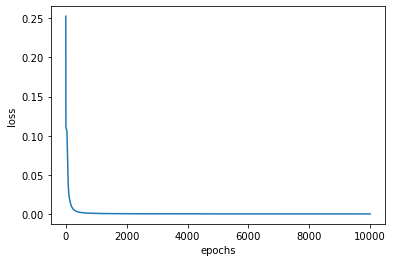

AE Reconstruction


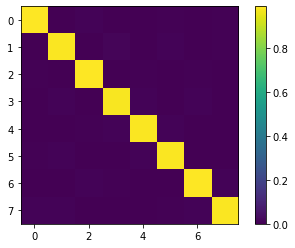

Ground Truth


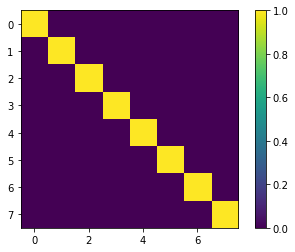

Residual: 0.005020710008922803


In [2]:
# Defining neccessary hyperparameters for the autoencoder
nn_architecture = [{'input_dim': 8, 'output_dim': 3, 'activation': 'sigmoid'}, 
                   {'input_dim': 3, 'output_dim': 8, 'activation': 'sigmoid'}]
loss_function = 'mse'
learning_rate = 10
seed = 20
epochs = 10000

# Generating autoencoder NN class instance
identity_ae = NN.NeuralNetwork(nn_architecture, lr=learning_rate, seed=seed, epochs=epochs, loss_function=loss_function)

# Defining Data for use in the autoencoder
X = np.eye(8,8)
y = X

# Training the Auto Encoder
per_epoch_loss_train, per_epoch_loss_val, _, _ = identity_ae.fit(X, y, X, y)

# plotting Loss Curve
fig = plt.figure()
plt.plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Plotting input vs output to show comparability
print('AE Reconstruction')
plt.imshow(identity_ae.predict(X))
plt.colorbar()
plt.show()
print('Ground Truth')
plt.imshow(X)
plt.colorbar()
plt.show()

# Calculating Residual.
res = np.mean(np.abs((identity_ae.predict(X) - X)))
print(f'Residual: {res}')

# Part 2: Adapt for classification, and develop training regime

## (2) Encoding DNA sequences

In [3]:
# Reading in postive sequences
positive_seqs = io.read_text_file('./data/rap1-lieb-positives.txt')

# Reading in upstream yeast sequences
pot_neg_seqs = io.read_fasta_file('./data/yeast-upstream-1k-negative.fa')

# Randomly sampling negative sequences
negative_seqs = preprocess.sample_negative_examples(pot_neg_seqs, positive_seqs, num_samples=1000, seq_length=17)

# Generating labels
pos_labels = np.expand_dims(np.array([1]*len(positive_seqs)), axis=0)
neg_labels = np.expand_dims(np.array([0]*len(negative_seqs)), axis=0)
labels = np.swapaxes(np.hstack([pos_labels, neg_labels]), 0, 1)

# Generating Unraveled One Hot Encoded Input Feauture --> 4*seq_length
pos_input = preprocess.encode_seqs(positive_seqs)
neg_input = preprocess.encode_seqs(negative_seqs)

# Generating full inputs to network
inputs = np.vstack([pos_input, neg_input])

(a) The way that I chose to encode the DNA was with a flattened one hot encodeing method. Such that ever nucleotide is converted into a one hot encoded 4-bit vector where:

A --> 1, 0, 0, 0
T --> 0, 1, 0, 0
C --> 0, 0, 1, 0
G --> 0, 0, 0, 1

So in the case of 17-mers that I am using as an input into the Rap1 binding site classifier I get a 68-bit input vector. So for example:

ATG --> 1,0,0,0,0,1,0,0,0,0,0,0,1

I chose to implement it this way becuase I do not want to encode sequence in a ordinal manner, this method of encoding ensures that the network can learn from the entire 17-mer in the most agnostic way possible withou giving the network a predifiend notion of value associated with sequence.

## (3) Defining Training Regimine

The training regimine has to sample the negative examples in an intellegent way to ensure that it does not overweight the negative example and lead to all input sequences being classified as not a Rap1 binding site. The way that I did this was to randomly sample the negative sequenes, such that I chose a random index from each of the indivudal sequences in the fasta file where a 17-mer could be taken. And then if I want to sample more negative examples than there are sequenes upsteam of yeast genes, then I sample multiple 17-mers from each of the upstream regions. I also check to make sure that each of the negative examples are not contained in the postive example set to ensure the model is only specific to the Rap1 sites. I imlemented this in the sample_negative_examples function where you can chose the number of negative examples. Here I chose 1000 samples because it is more negative examples than the 137 positive samples, but not so many more samples that class imbalance causes an over prediction of negative binding sites. This training regimine results in a good classifier as can be seen in (4) below.

## (4) Training NN model to predict Rap1 binding

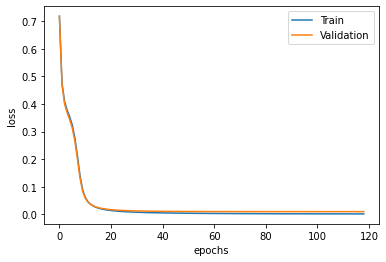

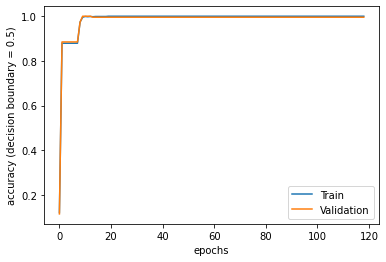

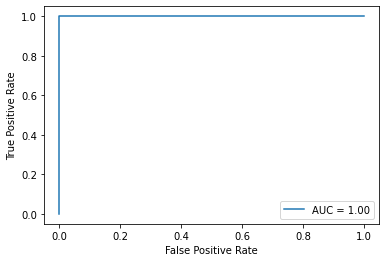

AUROC: 1.0
Final Epoch Accuracy: 0.995575221238938 



In [4]:
# Defining neccessary hyperparameters for the NN model
nn_architecture = [{'input_dim': 68, 'output_dim': 2, 'activation': 'relu'}, 
                   {'input_dim': 2, 'output_dim': 1, 'activation': 'sigmoid'}]
loss_function = 'binary_crossentropy'
learning_rate = 2
seed = 14
epochs = 1000
early_stop = [20, -1e-12]

# Generating NN class instance for binary classifier
bc_nn = NN.NeuralNetwork(nn_architecture, lr=learning_rate, seed=seed, epochs=epochs, loss_function=loss_function)

# Doing sinlge fold training split
X_train, X_val, y_train, y_val = preprocess.split_basic_binary(inputs, labels, split=[0.8, 0.2], shuffle=True)

# Making sure that there is no overlap between training and validation set
X_train_mod = [','.join(X.astype(int).astype(str)) for X in X_train]
train_set = set(X_train_mod)
X_val_mod = [','.join(X.astype(int).astype(str)) for X in X_val]
val_set = set(X_val_mod)
assert len(train_set & val_set) == 0

# Training Model
per_epoch_loss_train, per_epoch_loss_val, per_epoch_acc_train, per_epoch_acc_val = bc_nn.fit(X_train, y_train, X_val, y_val, early_stop=early_stop)

# Plotting Loss Curve
fig = plt.figure()
plt.plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
plt.plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
plt.legend(['Train', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Plotting Accuracy Curve
fig = plt.figure()
plt.plot(np.arange(len(per_epoch_acc_train)), per_epoch_acc_train)
plt.plot(np.arange(len(per_epoch_acc_val)), per_epoch_acc_val)
plt.legend(['Train', 'Validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy (decision boundary = 0.5)')
plt.show()

# Plotting AUROC
auroc = bc_nn.calculate_auroc(X_val, y_val, n_steps=1000)
print(f'AUROC: {auroc}')
print(f'Final Epoch Accuracy: {per_epoch_acc_val[-1]} \n')


(a) **Providing an example of positive and negative input and output**

In [5]:
print('\n')

# positive input
pos_ex = np.expand_dims(pos_input[0, :], axis=0)
print('positive encoded sequence:', pos_ex)

# positive output
print('positve prediction:', np.squeeze(bc_nn.predict(pos_ex)))
print('\n')

# negative input
neg_ex = np.expand_dims(neg_input[0, :], axis=0)
print('negative encoded sequence:', neg_ex)

# negative output
print('negative prediction:', np.squeeze(bc_nn.predict(neg_ex)))
print('\n')



positive encoded sequence: [[1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]]
positve prediction: 0.9990513449188126


negative encoded sequence: [[0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]]
negative prediction: 4.4606564021759655e-05




(b) The network architecture that I chose was a 68 x 2 x 1 binary classificaiton network where the hidden unit of 2 dimesnions has a ReLU activation function and the final layer has a sigmoid activation function. The network did a good job at minimizing the binary crossentropy loss function as is evident by the loss curves plotted above. In addition the positive and negative predictions are quite accurate as is shown above.

(c) The stopping criteria that I used for training the network was a early stopping scheme where if the validation accurcy decreased for more than 10 epochs at a rate less than 1e-12 or increased for more than 10 epochs, then the network stopped training. This was to ensure that overfitting would not occur, which would be the case if the validation loss began to increase, as well as ensure that the model stopped training when deemed no longer neccessary. I found 1e-12 threshold to be a good point at which the model performance no longer had a substantial epoch over epoch increase in accuracy.

# Part 3: Cross-Validation

## (5) K-fold CV for Evaluating NN Model's Classification

(a) K-fold cross validation allows you to train and test on different cross sections of the same dataset. Training on all but one fold and testing on the held out fold and iterating through all the folds in your datasets allows you to make sure that the model isn't overfitting and that there was not just one particular split of the data that resulting in good predictions. This K-fold cross validation is used commonly in machine learning to make sure that the model is actually learning a pattern and not learning from noise present in a certain fold. Also in the case of my K-fold CV I made sure to stratify based on the labels, such that each fold had an equal proportion of positive to negative labels.

(b) I chose k=10 for this dataset, because with 137 positive sequences this resulted in roughly 13 positive sequences per fold and with 1000 negative samples each fold got 100 negative sequences per fold. Thus, each hold out fold still had a good numner of positive sequenes to test e.g. good positive sequence diversity, but with a larger fold split than for example 5 (the other commonly used K in the field of machine learning) this allowed the 10-fold split to ensure the model did not just have some splits that by random chance resulted in good predictions.

(c) I chose the AUROC metric, as this is the most commonly used metric for testing for good classificaiton performance. In a 10-fold cross-validation scheme the model had an average AUROC of 1 and an average final accuracy with decision boundary 0.5 of 0.999123. This leads me to believe that my model is doing a very good job at classifying Rap1 binding sites.

See below for more in depth view of cross validation process

Fold 0
-------


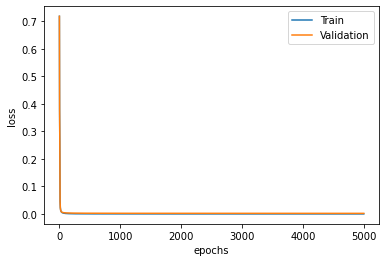

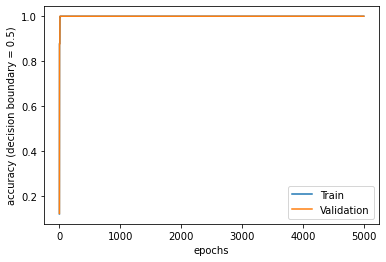

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 1
-------


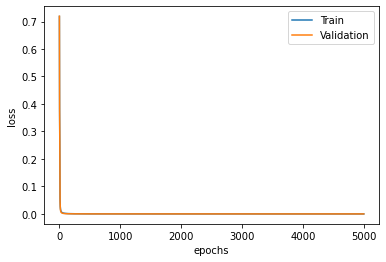

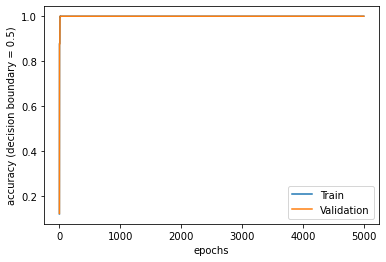

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 2
-------


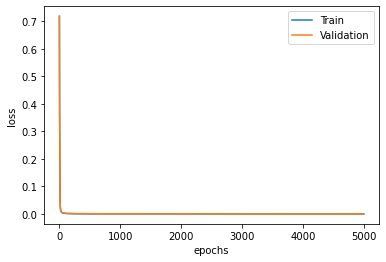

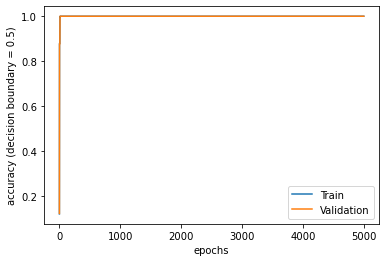

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 3
-------


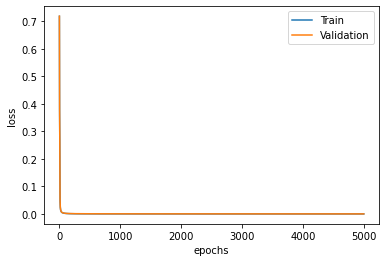

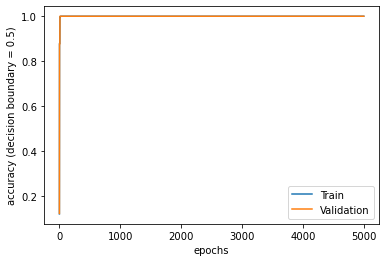

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 4
-------


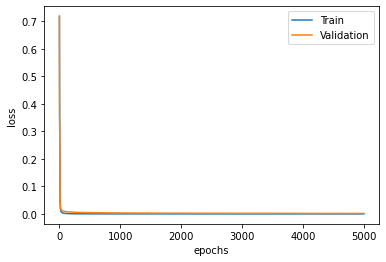

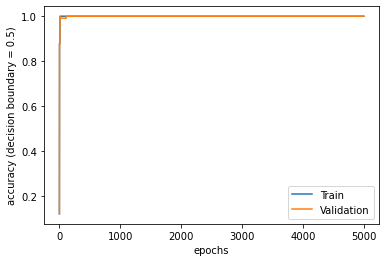

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 5
-------


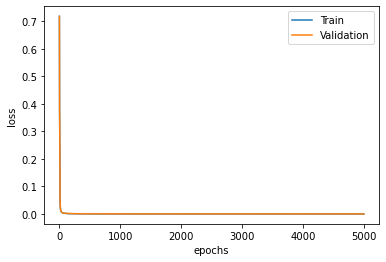

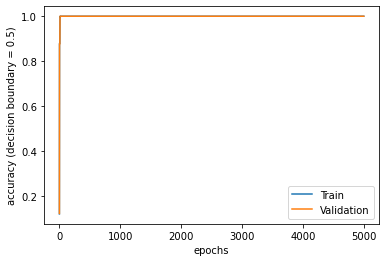

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 6
-------


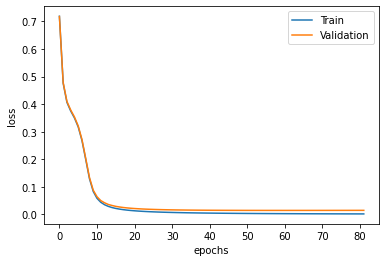

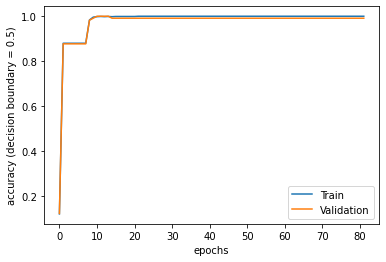

AUROC: 1.0
Final Epoch Accuracy: 0.9912280701754386
---------------------------------------------------

Fold 7
-------


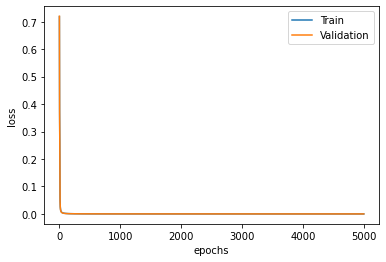

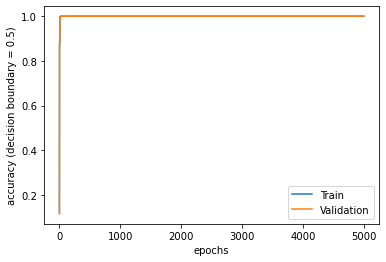

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 8
-------


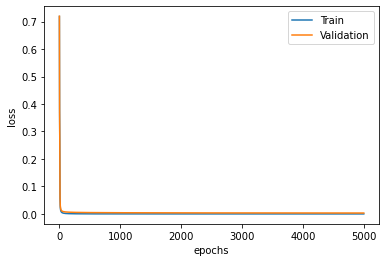

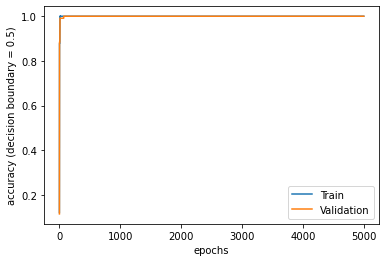

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Fold 9
-------


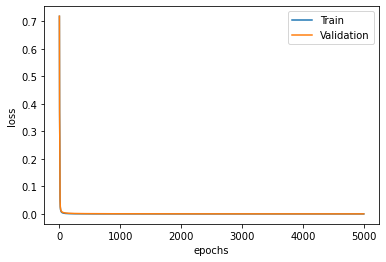

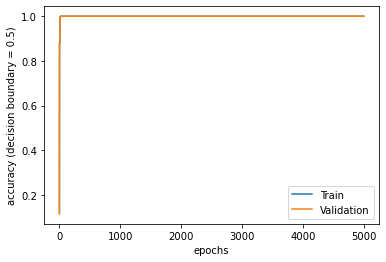

AUROC: 1.0
Final Epoch Accuracy: 1.0
---------------------------------------------------

Average Fold AUROC: 1.0
Average Fold Final Acc: 0.9991228070175439


In [10]:
# Defining neccessary hyperparameters for the NN model
nn_architecture = [{'input_dim': 68, 'output_dim': 2, 'activation': 'relu'},
                   {'input_dim': 2, 'output_dim': 1, 'activation': 'sigmoid'}]
loss_function = 'binary_crossentropy'
learning_rate = 2
seed = 14
epochs = 5000
early_stop = [20, -1e-12]

# Running K-fold CV
num_folds = 10
kf_data = preprocess.KFoldCV(inputs, y=labels, num_folds=num_folds, shuffle=True)
fold_aurocs = []
fold_final_accs = []
for fold in range(num_folds):
    print(f'Fold {fold}')
    print('-------')
    # Generating Neural Network class instance
    bc_nn = NN.NeuralNetwork(nn_architecture, lr=learning_rate, seed=seed, epochs=epochs, loss_function=loss_function)
    X_train, X_val, y_train, y_val = kf_data.get_fold(fold)
    
    # Making sure that there is no overlap between training and validation set
    X_train_mod = [','.join(X.astype(int).astype(str)) for X in X_train]
    train_set = set(X_train_mod)
    X_val_mod = [','.join(X.astype(int).astype(str)) for X in X_val]
    val_set = set(X_val_mod)
    assert len(train_set & val_set) == 0
    
    # Training Neural Network
    per_epoch_loss_train, per_epoch_loss_val, per_epoch_acc_train, per_epoch_acc_val = bc_nn.fit(X_train, y_train, X_val, y_val, early_stop=early_stop)
    
    # Plotting the Loss curves
    fig = plt.figure()
    plt.plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
    plt.plot(np.arange(len(per_epoch_loss_val)), per_epoch_loss_val)
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    fig = plt.figure()
    plt.plot(np.arange(len(per_epoch_acc_train)), per_epoch_acc_train)
    plt.plot(np.arange(len(per_epoch_acc_val)), per_epoch_acc_val)
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy (decision boundary = 0.5)')
    plt.show()
    
    auroc = bc_nn.calculate_auroc(X_val, y_val, n_steps=1000, make_plot=False)
    fold_aurocs.append(auroc)
    fold_final_accs.append(per_epoch_acc_val[-1])
    print(f'AUROC: {auroc}')
    print(f'Final Epoch Accuracy: {per_epoch_acc_val[-1]}')
    print('---------------------------------------------------\n')

print(f'Average Fold AUROC: {np.mean(np.array(fold_aurocs))}')
print(f'Average Fold Final Acc: {np.mean(np.array(fold_final_accs))}')

# Part 4: Project Extension

# Part 5: Evaluating Model on Final Set

# Part 6: Automated Testing with Github Workflows